In [1]:
import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt

import os
import sys
from pathlib import Path
module_path = Path.cwd().parent / 'utils'
sys.path.append(str(module_path))
import data_processing
from simulations import *
module_path = Path.cwd().parent / 'execute'
sys.path.append(str(module_path))
import surv_hivae, surv_gan, surv_vae

import json
import optuna

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : OpenMP library not found, it must be downloaded through Homebrew for apple Silicon chips
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


## Simulate the initial data

In [2]:
n_samples = 600
n_features_bytype = 6
n_active_features = 3 
treatment_effect = 0.
p_treated = 0.5
shape_T = 2.
shape_C = 2.
scale_C = 2.5
scale_C_indep = 3.9
feature_types_list = ["real", "cat"]
independent = True
data_types_create = True

control, treated, types = simulation(treatment_effect, n_samples, independent, feature_types_list,
                                         n_features_bytype, n_active_features, p_treated, shape_T,
                                         shape_C, scale_C, scale_C_indep, data_types_create, seed=0)

control = control.drop(columns='treatment')
treated = treated.drop(columns='treatment')

In [3]:
control.head()

,0,1,2,3,4,5,6,7,8,9,10,11,time,censor
1,-0.620116,-0.987304,0.494666,0.166897,-1.119509,-0.210453,0.0,0.0,1.0,0.0,0.0,0.0,0.498643,1
4,0.874445,0.820363,1.377438,0.452029,0.226290,0.216713,1.0,1.0,1.0,1.0,1.0,1.0,2.070134,0
11,0.386280,0.632000,1.038750,0.349346,-0.678958,0.541789,0.0,1.0,1.0,1.0,0.0,1.0,2.516820,1
12,1.453227,0.145134,-0.593687,-1.056960,-2.069638,-2.300999,0.0,0.0,0.0,0.0,0.0,0.0,0.373784,0
14,-0.461897,-1.139139,-0.494944,0.213642,-0.509902,-1.174044,0.0,0.0,0.0,0.0,0.0,0.0,0.646194,1


In [4]:
print("percent of uncensored data in control set {:.3f} and in treated set {:.3f}".format(np.mean(control['censor']), 
                                                                                          np.mean(treated['censor'])))

percent of uncensored data in control set 0.840 and in treated set 0.843


## Save data

In [5]:
dataset_name = "Simulations"

current_path = os.getcwd()  # Get current working directory
parent_path = os.path.dirname(current_path)
data_file_control = parent_path + "/dataset/" + dataset_name + "/data_control.csv"
feat_types_file_control = parent_path + "/dataset/" + dataset_name + "/data_types_control.csv"
data_file_treated = parent_path + "/dataset/" + dataset_name + "/data_treated.csv"
feat_types_file_treated = parent_path + "/dataset/" + dataset_name + "/data_types_treated.csv"

# If the dataset has no missing data, leave the "miss_file" variable empty
miss_file = parent_path + "/dataset/" + dataset_name + "/Missing.csv"
true_miss_file = None

control.to_csv(data_file_control, index=False, header=False)
types.to_csv(feat_types_file_control)
treated.to_csv(data_file_treated, index=False, header=False)
types.to_csv(feat_types_file_treated)

## Load data

In [6]:
# Load and transform control data
df_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control, feat_types_file_control, miss_file, true_miss_file)
data_init_control_encoded = torch.from_numpy(df_init_control_encoded.values)
data_init_control = data_processing.discrete_variables_transformation(data_init_control_encoded, feat_types_dict)

# Load and transform treated data
df_init_treated_encoded, _, _, _, _ = data_processing.read_data(data_file_treated, feat_types_file_treated, miss_file, true_miss_file)
data_init_treated_encoded = torch.from_numpy(df_init_treated_encoded.values)
data_init_treated = data_processing.discrete_variables_transformation(data_init_treated_encoded, feat_types_dict)

In [7]:
fnames = types['name'][:-1].tolist()
fnames.append("time")#.append("censor")
fnames.append("censor")

In [8]:
# Format data in dataframe
df_init_treated = pd.DataFrame(data_init_treated.numpy(), columns=fnames)
df_init_control = pd.DataFrame(data_init_control.numpy(), columns=fnames)

# Update dataframe
df_init_treated["treatment"] = 1
df_init_control["treatment"] = 0
df_init = pd.concat([df_init_control, df_init_treated], ignore_index=True)

### Hyperparameters optimization

In [9]:
# Parameters of the optuna study

# metric_optuna = "log_rank_test" # metric to optimize in optuna
n_splits = 5 # number of splits for cross-validation
n_generated_dataset = 50 # number of generated datasets per fold to compute the metric
name_config = "simu_N{}_nfeat{}_t{}".format(n_samples, n_features_bytype, int(treatment_effect))

In [10]:
# # the datasets used for training is data_init_control
# T_surv = torch.Tensor(df_init_control.time)
# T_surv_norm = (T_surv - T_surv.min()) / (T_surv.max() - T_surv.min())
# n_intervals = 10
# T_intervals = torch.linspace(0., T_surv_norm.max(), n_intervals)
# T_intervals = torch.cat([T_intervals, torch.tensor([2 * T_intervals[-1] - T_intervals[-2]])])
# intervals = [(T_intervals[i].item(), T_intervals[i + 1].item()) for i in range(len(T_intervals) - 1)]

### Load best params and optuna study

In [ ]:
generators_sel = ["HI-VAE_weibull"] #, "HI-VAE_piecewise", "Surv-GAN", "Surv-VAE"]
generators_dict = {"HI-VAE_weibull" : surv_hivae,
                   "HI-VAE_piecewise" : surv_hivae,
                   "Surv-GAN" : surv_gan,
                   "Surv-VAE" : surv_vae}

original_dir = os.getcwd()

metric_optuna = "log_rank_test"
best_params_dict_logrank, study_dict_longrank = {}, {}
for generator_name in generators_sel:
    n_trials = 150
    study_name_cluster = "/home/pchassat/HI-VAE_Pytorch/dataset/Simulations_2/optuna_results/optuna_study_{}_ntrials{}_{}_{}".format(name_config, n_trials, metric_optuna, generator_name)
    study_name = "dataset/" + dataset_name + "/optuna_results/optuna_study_{}_ntrials{}_{}_{}".format(name_config, n_trials, metric_optuna, generator_name)
    best_params_file = "dataset/" + dataset_name + "/optuna_results/best_params_{}_ntrials{}_{}_{}.json".format(name_config, n_trials, metric_optuna, generator_name)
    db_file = study_name + ".db"
    if os.path.exists(db_file):
        print("This optuna study already exists. Please change the name of the study or remove the file to create a new one.")
        study = optuna.load_study(study_name=study_name_cluster, storage="sqlite:///{}".format(db_file))
        study_dict_longrank[generator_name] = study
        with open(best_params_file, "r") as f:
            best_params_dict_logrank[generator_name] = json.load(f)
    else:
        raise FileNotFoundError("The optuna study does not exist. Please create it first.")


metric_optuna = "survival_km_distance"
best_params_dict_survkm, study_dict_survkm = {}, {}
for generator_name in generators_sel:
    n_trials = 150
    study_name_cluster = "/home/pchassat/HI-VAE_Pytorch/dataset/Simulations_2/optuna_results/optuna_study_{}_ntrials{}_{}_{}".format(name_config, n_trials, metric_optuna, generator_name)
    study_name = "dataset/" + dataset_name + "/optuna_results/optuna_study_{}_ntrials{}_{}_{}".format(name_config, n_trials, metric_optuna, generator_name)
    best_params_file = "dataset/" + dataset_name + "/optuna_results/best_params_{}_ntrials{}_{}_{}.json".format(name_config, n_trials, metric_optuna, generator_name)
    db_file = study_name + ".db"
    if os.path.exists(db_file):
        print("This optuna study already exists. Please change the name of the study or remove the file to create a new one.")
        study = optuna.load_study(study_name=study_name_cluster, storage="sqlite:///{}".format(db_file))
        study_dict_survkm[generator_name] = study
        with open(best_params_file, "r") as f:
            best_params_dict_survkm[generator_name] = json.load(f)
    else:
        raise FileNotFoundError("The optuna study does not exist. Please create it first.")
    

In [ ]:
# best_params_hivae_weibull = best_params_dict["HI-VAE_weibull"]
# best_params_hivae_piecewise = best_params_dict["HI-VAE_piecewise"]
# best_params_survgan = best_params_dict["Surv-GAN"]
# best_params_survae = best_params_dict["Surv-VAE"]

print("Best parameters for HI-VAE Weibull:")
print(" - with survival_km_distance: {}".format(best_params_dict_survkm["HI-VAE_weibull"]))
print(" - with log_rank_test: {}".format(best_params_dict_logrank["HI-VAE_weibull"]))
print('\n')
print("Best parameters for HI-VAE Piecewise:")
print(" - with survival_km_distance: {}".format(best_params_dict_survkm["HI-VAE_piecewise"]))
print(" - with log_rank_test: {}".format(best_params_dict_logrank["HI-VAE_piecewise"]))
print('\n')
print("Best parameters for Surv-GAN:")
print(" - with survival_km_distance: {}".format(best_params_dict_survkm["Surv-GAN"]))
print(" - with log_rank_test: {}".format(best_params_dict_logrank["Surv-GAN"]))
print('\n')
print("Best parameters for Surv-VAE:")
print(" - with survival_km_distance: {}".format(best_params_dict_survkm["Surv-VAE"]))
print(" - with log_rank_test: {}".format(best_params_dict_logrank["Surv-VAE"])) 

In [12]:
# Visualize the results of the optuna study

from optuna.visualization import plot_slice
from optuna.visualization import plot_optimization_history

print('---------------------- surv_km distance ----------------------')
fig = plot_slice(study_dict_survkm["HI-VAE_weibull"])
fig.show()

fig = plot_optimization_history(study_dict_survkm["HI-VAE_weibull"])
fig.show()

---------------------- surv_km distance ----------------------


In [14]:
print('----------------------  log rank test ----------------------')

fig = plot_slice(study_dict_longrank["HI-VAE_weibull"])
fig.show()

fig = plot_optimization_history(study_dict_longrank["HI-VAE_weibull"])
fig.show()

----------------------  log rank test ----------------------


## 2. Training and generation from the generative model

Possible generative models: HI-VAE (our), survival_gan, survival_ctgan, survival_nflow, survae (synthcity)

### Run with defaut_params

In [13]:
# the datasets used for training is data_init_control
n_generated_dataset = 1
generators_sel = ["HI-VAE_weibull"] #, "HI-VAE_piecewise", "Surv-GAN", "Surv-VAE"]
data_gen_control_dict = {}
for generator_name in generators_sel:
    print("=" * 100)
    print("Generate data by " + generator_name)
    if generator_name in ["HI-VAE_weibull", "HI-VAE_piecewise"]:
        feat_types_dict_ext = feat_types_dict.copy()
        for i in range(len(feat_types_dict)):
            if feat_types_dict_ext[i]['name'] == "survcens":
                if generator_name in["HI-VAE_weibull"]:
                    feat_types_dict_ext[i]["type"] = 'surv_weibull'
                else:
                    feat_types_dict_ext[i]["type"] = 'surv_piecewise'
        data_gen_control_dict[generator_name] = generators_dict[generator_name].run(df_init_control_encoded, miss_mask_control, true_miss_mask_control, feat_types_dict_ext, n_generated_dataset, epochs=1500)
    else:
        data_gen_control_dict[generator_name] = generators_dict[generator_name].run(data_init_control, columns=fnames, target_column="censor", time_to_event_column="time", n_generated_dataset=n_generated_dataset)

Generate data by HI-VAE_weibull
Epoch: [ 0]  time: 0.1653, ELBO_train: -22.66010284, KL_z: 2.53682500, KL_s: 0.10640180, reconstruction loss: -20.01687604
Epoch: [100]  time: 1.9854, ELBO_train: -18.21805000, KL_z: 1.43760574, KL_s: 0.07889426, reconstruction loss: -16.70155001
Epoch: [200]  time: 3.9828, ELBO_train: -17.65159369, KL_z: 1.81032401, KL_s: 0.06753266, reconstruction loss: -15.77373701
Epoch: [300]  time: 5.8940, ELBO_train: -17.57460499, KL_z: 2.22710347, KL_s: 0.06943917, reconstruction loss: -15.27806234
Epoch: [400]  time: 8.2754, ELBO_train: -17.27561092, KL_z: 2.46223891, KL_s: 0.07816231, reconstruction loss: -14.73520970
Epoch: [500]  time: 10.0535, ELBO_train: -17.18310547, KL_z: 2.63894278, KL_s: 0.08305871, reconstruction loss: -14.46110398
Epoch: [600]  time: 11.9225, ELBO_train: -17.41201258, KL_z: 2.71797985, KL_s: 0.08107781, reconstruction loss: -14.61295491
Epoch: [700]  time: 13.8555, ELBO_train: -17.15367699, KL_z: 2.84584093, KL_s: 0.07911050, reconstr

### Run with best params surv_km_dist

In [14]:
generators_sel = ["HI-VAE_weibull"] #, "HI-VAE_piecewise", "Surv-GAN", "Surv-VAE"]
data_gen_control_dict_best_params_survkm = {}
for generator_name in generators_sel:
    print("=" * 100)
    print("Generate data by " + generator_name)
    best_params = best_params_dict_survkm[generator_name]
    if generator_name in ["HI-VAE_weibull", "HI-VAE_piecewise"]:
        feat_types_dict_ext = feat_types_dict.copy()
        for i in range(len(feat_types_dict)):
            if feat_types_dict_ext[i]['name'] == "survcens":
                if generator_name in["HI-VAE_weibull"]:
                    feat_types_dict_ext[i]["type"] = 'surv_weibull'
                else:
                    feat_types_dict_ext[i]["type"] = 'surv_piecewise'
        data_gen_control_dict_best_params_survkm[generator_name] = generators_dict[generator_name].run(df_init_control_encoded,
                                                                                                miss_mask_control,
                                                                                                true_miss_mask_control, 
                                                                                                feat_types_dict_ext, 
                                                                                                n_generated_dataset, 
                                                                                                params=best_params, 
                                                                                                epochs = 1500)
    else:
        data_gen_control_dict_best_params_survkm[generator_name] = generators_dict[generator_name].run(data_init_control, 
                                                                                                columns=fnames, 
                                                                                                target_column="censor", 
                                                                                                time_to_event_column="time", 
                                                                                                n_generated_dataset=n_generated_dataset, 
                                                                                                params=best_params)

Generate data by HI-VAE_weibull
Epoch: [ 0]  time: 0.0303, ELBO_train: -17.69461513, KL_z: 0.46900793, KL_s: 0.08111399, reconstruction loss: -17.14449320
Epoch: [100]  time: 2.9509, ELBO_train: -14.72075629, KL_z: 1.63517112, KL_s: 0.05816340, reconstruction loss: -13.02742177
Epoch: [200]  time: 5.5468, ELBO_train: -14.55438876, KL_z: 2.06993657, KL_s: 0.05354297, reconstruction loss: -12.43090922
Epoch: [300]  time: 8.1499, ELBO_train: -14.46479416, KL_z: 2.29598981, KL_s: 0.04564744, reconstruction loss: -12.12315691
Epoch: [400]  time: 10.7688, ELBO_train: -14.32158852, KL_z: 2.39357859, KL_s: 0.05423814, reconstruction loss: -11.87377179
Epoch: [500]  time: 13.4039, ELBO_train: -14.52188444, KL_z: 2.48009771, KL_s: 0.05490428, reconstruction loss: -11.98688245
Epoch: [600]  time: 16.3443, ELBO_train: -14.37524605, KL_z: 2.57825142, KL_s: 0.06340986, reconstruction loss: -11.73358476
Epoch: [700]  time: 19.1039, ELBO_train: -14.21444726, KL_z: 2.59577572, KL_s: 0.05760056, reconst

### Run with best params logrank

In [ ]:
generators_sel = ["HI-VAE_weibull"] #, "HI-VAE_piecewise", "Surv-GAN", "Surv-VAE"]
data_gen_control_dict_best_params_logrank = {}
for generator_name in generators_sel:
    print("=" * 100)
    print("Generate data by " + generator_name)
    best_params = best_params_dict_logrank[generator_name]
    if generator_name in ["HI-VAE_weibull", "HI-VAE_piecewise"]:
        feat_types_dict_ext = feat_types_dict.copy()
        for i in range(len(feat_types_dict)):
            if feat_types_dict_ext[i]['name'] == "survcens":
                if generator_name in["HI-VAE_weibull"]:
                    feat_types_dict_ext[i]["type"] = 'surv_weibull'
                else:
                    feat_types_dict_ext[i]["type"] = 'surv_piecewise'
        data_gen_control_dict_best_params_logrank[generator_name] = generators_dict[generator_name].run(df_init_control_encoded,
                                                                                                miss_mask_control,
                                                                                                true_miss_mask_control, 
                                                                                                feat_types_dict_ext, 
                                                                                                n_generated_dataset, 
                                                                                                params=best_params,
                                                                                                epochs=1500)
    else:
        data_gen_control_dict_best_params_logrank[generator_name] = generators_dict[generator_name].run(data_init_control, 
                                                                                                columns=fnames, 
                                                                                                target_column="censor", 
                                                                                                time_to_event_column="time", 
                                                                                                n_generated_dataset=n_generated_dataset, 
                                                                                                params=best_params)

Generate data by HI-VAE_weibull
Epoch: [ 0]  time: 0.0495, ELBO_train: -16.34393907, KL_z: 2.93188864, KL_s: 0.06503779, reconstruction loss: -13.34701264
Epoch: [100]  time: 3.1036, ELBO_train: -12.02446723, KL_z: 1.24173814, KL_s: 0.07102281, reconstruction loss: -10.71170628
Epoch: [200]  time: 6.7134, ELBO_train: -11.97555828, KL_z: 1.55736727, KL_s: 0.05931962, reconstruction loss: -10.35887140
Epoch: [300]  time: 10.3677, ELBO_train: -11.54295778, KL_z: 1.70746657, KL_s: 0.05351484, reconstruction loss: -9.78197637
Epoch: [400]  time: 13.8852, ELBO_train: -11.49948454, KL_z: 1.82275531, KL_s: 0.05132675, reconstruction loss: -9.62540248
Epoch: [500]  time: 17.6624, ELBO_train: -11.49846959, KL_z: 1.96530178, KL_s: 0.06118792, reconstruction loss: -9.47197989
Epoch: [600]  time: 21.7551, ELBO_train: -11.70406055, KL_z: 1.93547514, KL_s: 0.07122672, reconstruction loss: -9.69735870
Epoch: [700]  time: 25.3435, ELBO_train: -11.26536798, KL_z: 2.03543508, KL_s: 0.06627578, reconstruc

[2025-06-16T00:54:40.949992+0200][3511][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-16T00:54:40.951955+0200][3511][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-16T00:54:40.952495+0200][3511][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-16T00:54:40.952993+0200][3511][CRITICAL] module plugin_decaf load failed
[2025-06-16T00:54:41.050442+0200][3511][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-16T00:54:41.051702+0200][3511][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-16T00:54:41.052325+0200][3511][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-16T00:54:41.052860+0200][3511][

Training finished.
Generate data by Surv-GAN


  6%|▋         | 649/10000 [00:19<04:47, 32.48it/s]
[2025-06-16T00:55:13.662633+0200][3511][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-16T00:55:13.663738+0200][3511][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-16T00:55:13.664311+0200][3511][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-16T00:55:13.664772+0200][3511][CRITICAL] module plugin_decaf load failed
[2025-06-16T00:55:13.698488+0200][3511][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-16T00:55:13.699590+0200][3511][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-16T00:55:13.700147+0200][3511][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribu

Generate data by Surv-VAE


100%|██████████| 100/100 [00:05<00:00, 17.65it/s]


### Plot survival curves

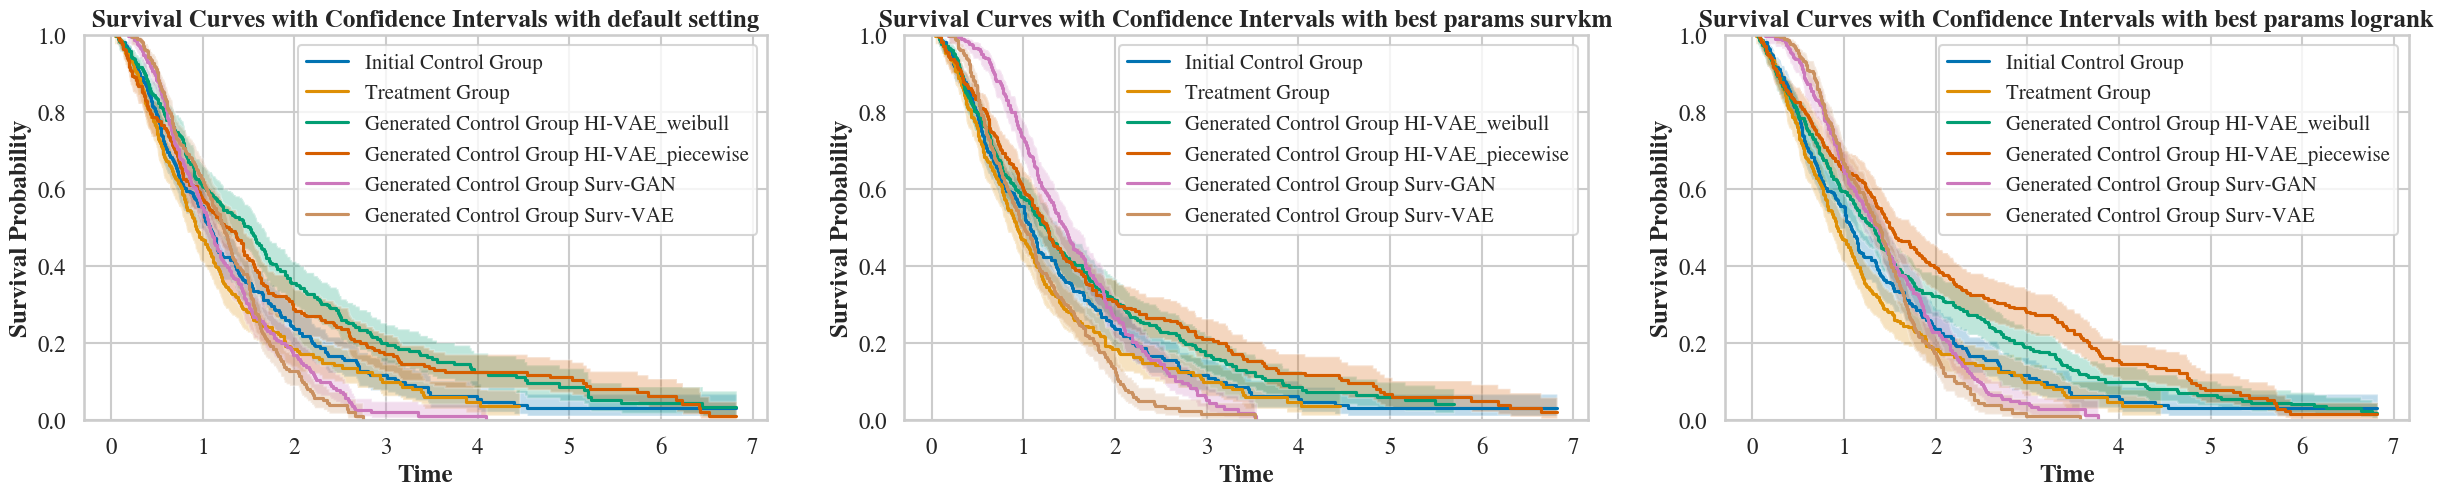

In [20]:
from sksurv.nonparametric import kaplan_meier_estimator

def kaplan_meier_estimation(surv_data, label=None, ax=None):
    surv_time  = surv_data['time'].values
    surv_ind = surv_data['censor'].values.astype(bool)
    uniq_time, surv_prob, conf_int = kaplan_meier_estimator(surv_ind, surv_time, conf_type="log-log")

    ax.step(uniq_time, surv_prob, where="post", label=label)
    ax.fill_between(uniq_time, conf_int[0], conf_int[1], alpha=0.25, step="post")

fig, axs = plt.subplots(1, 3, figsize=(30, 5))

kaplan_meier_estimation(control, label="Initial Control Group", ax=axs[0])
kaplan_meier_estimation(treated, label="Treatment Group", ax=axs[0])
sel_dataset_idx = 0
for i, generator_name in enumerate(generators_sel):
    df_syn_sel = pd.DataFrame(data_gen_control_dict[generator_name][sel_dataset_idx].numpy(), columns=fnames)
    kaplan_meier_estimation(df_syn_sel, label="Generated Control Group " + generator_name, ax=axs[0])
axs[0].set_ylim(0, 1)
axs[0].legend(fontsize=15)
axs[0].set_xlabel("Time", fontweight="semibold")
axs[0].set_ylabel("Survival Probability", fontweight="semibold")
axs[0].set_title("Survival Curves with Confidence Intervals with default setting", fontweight="bold")


kaplan_meier_estimation(control, label="Initial Control Group", ax=axs[1])
kaplan_meier_estimation(treated, label="Treatment Group", ax=axs[1])
sel_dataset_idx = 0
for i, generator_name in enumerate(generators_sel):
    df_syn_sel = pd.DataFrame(data_gen_control_dict_best_params_survkm[generator_name][sel_dataset_idx].numpy(), columns=fnames)
    kaplan_meier_estimation(df_syn_sel, label="Generated Control Group " + generator_name, ax=axs[1])
axs[1].set_ylim(0, 1)
axs[1].legend(fontsize=15)
axs[1].set_xlabel("Time", fontweight="semibold")
axs[1].set_ylabel("Survival Probability", fontweight="semibold")
axs[1].set_title("Survival Curves with Confidence Intervals with best params survkm", fontweight="bold")


kaplan_meier_estimation(control, label="Initial Control Group", ax=axs[2])
kaplan_meier_estimation(treated, label="Treatment Group", ax=axs[2])
sel_dataset_idx = 0
for i, generator_name in enumerate(generators_sel):
    df_syn_sel = pd.DataFrame(data_gen_control_dict_best_params_logrank[generator_name][sel_dataset_idx].numpy(), columns=fnames)
    kaplan_meier_estimation(df_syn_sel, label="Generated Control Group " + generator_name, ax=axs[2])
axs[2].set_ylim(0, 1)
axs[2].legend(fontsize=15)
axs[2].set_xlabel("Time", fontweight="semibold")
axs[2].set_ylabel("Survival Probability", fontweight="semibold")
axs[2].set_title("Survival Curves with Confidence Intervals with best params logrank", fontweight="bold")

plt.show()

In [21]:
# Convert generated data into dataframe
df_gen_control_dict_best_params_survkm = {}
df_gen_control_dict_best_params_logrank = {}
df_gen_control_dict_default = {}
df_syn_dict_best_params_survkm = {}
df_syn_dict_best_params_logrank = {}
df_syn_dict_default = {}
for generator_name in generators_sel:
    list_df_gen_control_best_params_survkm = []
    list_df_gen_control_best_params_logrank = []
    list_df_gen_control_default = []
    data_syn_best_params_survkm = []
    data_syn_best_params_logrank = []
    data_syn_default = []
    for j in range(n_generated_dataset):
        df_gen_survkm_control_j = pd.DataFrame(data_gen_control_dict_best_params_survkm[generator_name][j].numpy(), columns=fnames)
        df_gen_survkm_control_j['treatment'] = 0
        list_df_gen_control_best_params_survkm.append(df_gen_survkm_control_j)
        data_syn_best_params_survkm.append(pd.concat([df_init_treated, df_gen_survkm_control_j], ignore_index=True))

        df_gen_logrank_control_j = pd.DataFrame(data_gen_control_dict_best_params_logrank[generator_name][j].numpy(), columns=fnames)
        df_gen_logrank_control_j['treatment'] = 0
        list_df_gen_control_best_params_logrank.append(df_gen_logrank_control_j)
        data_syn_best_params_logrank.append(pd.concat([df_init_treated, df_gen_logrank_control_j], ignore_index=True))

        df_gen_control_j = pd.DataFrame(data_gen_control_dict[generator_name][j].numpy(), columns=fnames)
        df_gen_control_j['treatment'] = 0
        list_df_gen_control_default.append(df_gen_control_j)
        data_syn_default.append(pd.concat([df_init_treated, df_gen_control_j], ignore_index=True))
        
    df_gen_control_dict_best_params_survkm[generator_name] = list_df_gen_control_best_params_survkm
    df_gen_control_dict_best_params_logrank[generator_name] = list_df_gen_control_best_params_logrank
    df_gen_control_dict_default[generator_name] = list_df_gen_control_default
    df_syn_dict_best_params_survkm[generator_name] = data_syn_best_params_survkm
    df_syn_dict_best_params_logrank[generator_name] = data_syn_best_params_logrank
    df_syn_dict_default[generator_name] = data_syn_default

### 3. Compare generation performance

#### 3.1. General metrics

In [22]:
from utils.metrics import general_metrics
general_scores_survkm = []
general_scores_default = []
general_scores_logrank = []
for generator_name in generators_sel:
    general_scores_survkm.append(general_metrics(df_init_control, df_gen_control_dict_best_params_survkm[generator_name], generator_name))
    general_scores_default.append(general_metrics(df_init_control, df_gen_control_dict_default[generator_name], generator_name))
    general_scores_logrank.append(general_metrics(df_init_control, df_gen_control_dict_best_params_logrank[generator_name], generator_name))
general_scores_default_df = pd.concat(general_scores_default)
general_scores_survkm_df = pd.concat(general_scores_survkm)
general_scores_logrank_df = pd.concat(general_scores_logrank)

##### 3.1.1. Data resemblance

===================== General performance with best params survkm: =====================


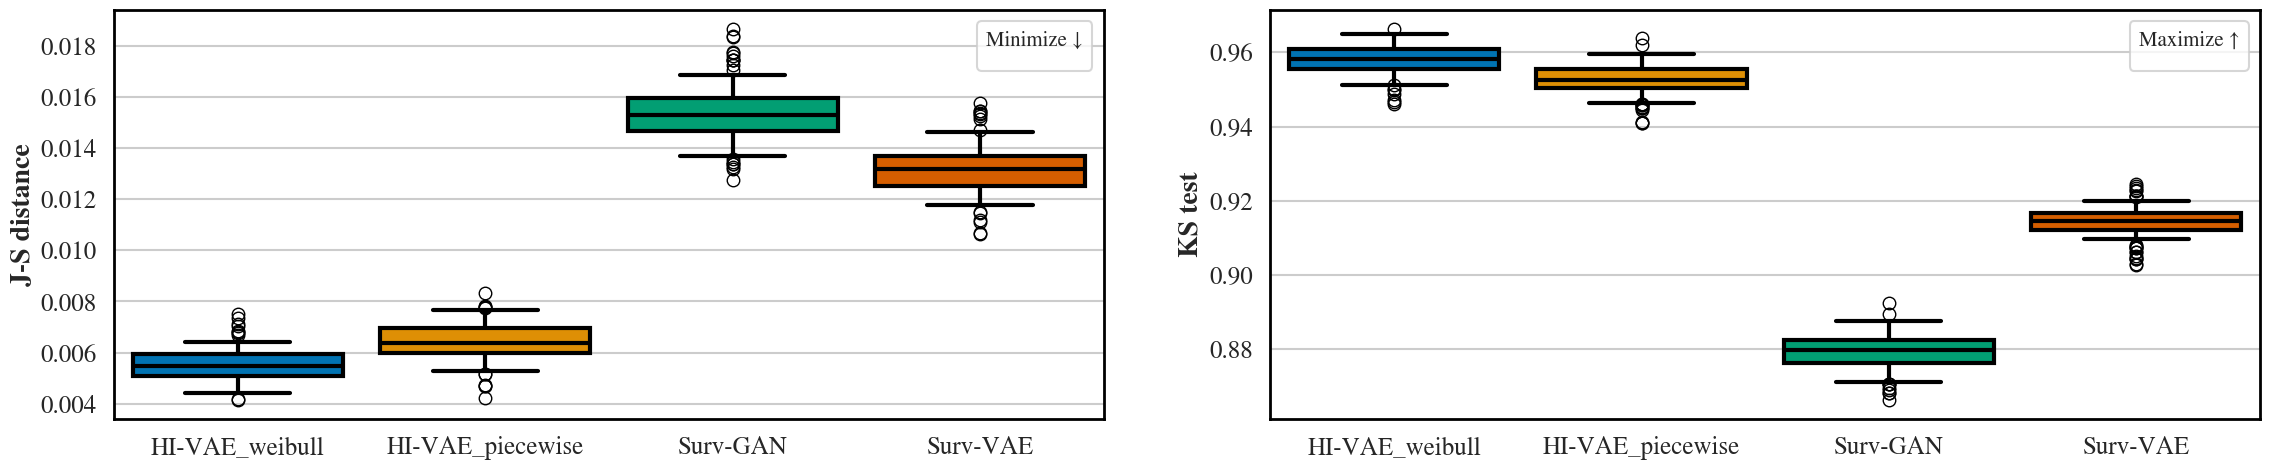

===================== General performance with best params logrank: =====================


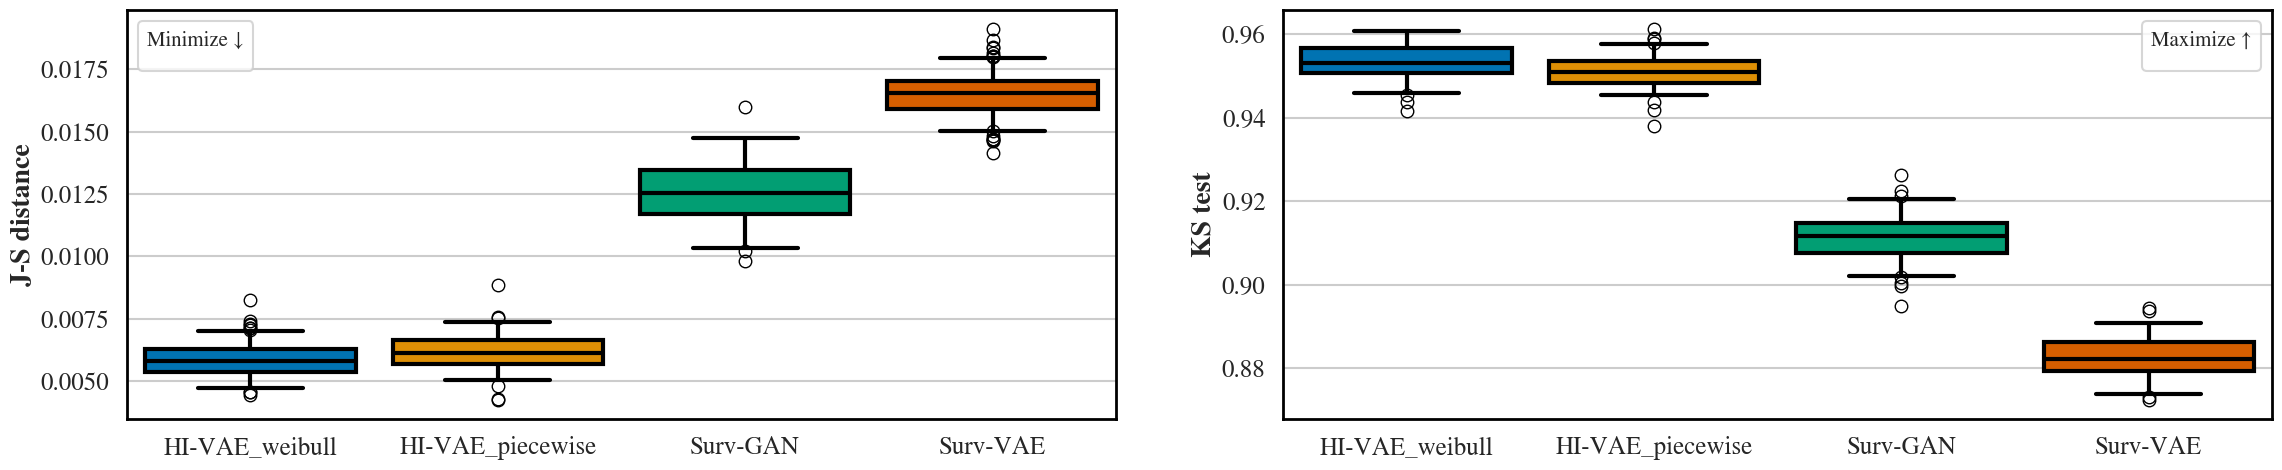

===================== General performance with default params: =====================


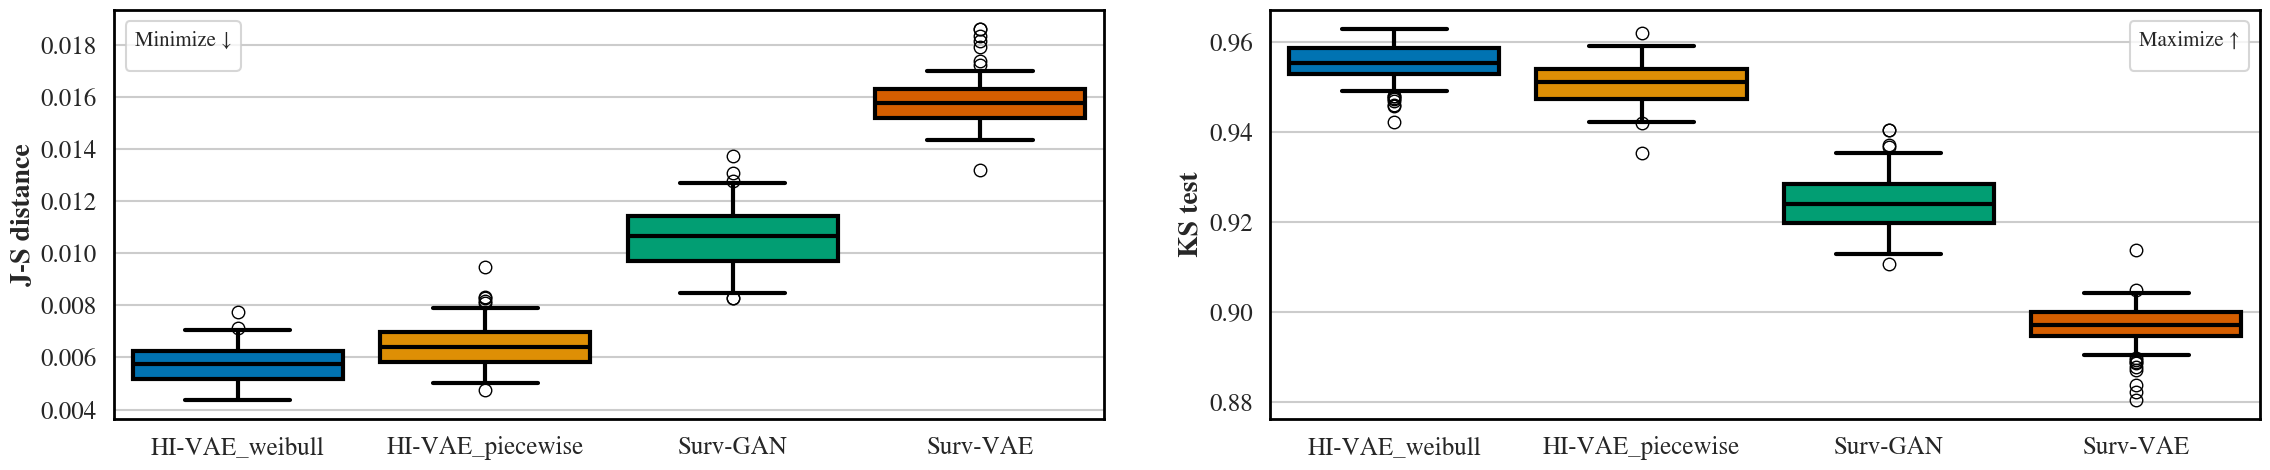

In [23]:
from utils.visualization import visualize_general_perf
print("===================== General performance with best params survkm: =====================")
visualize_general_perf(general_scores_survkm_df, metrics=[['J-S distance', "min"], ['KS test', "max"]])

print("===================== General performance with best params logrank: =====================")
visualize_general_perf(general_scores_logrank_df, metrics=[['J-S distance', "min"], ['KS test', "max"]])

print("===================== General performance with default params: =====================")
visualize_general_perf(general_scores_default_df, metrics=[['J-S distance', "min"], ['KS test', "max"]])

##### 3.1.2. Utility

===================== General performance with best params survkm: =====================


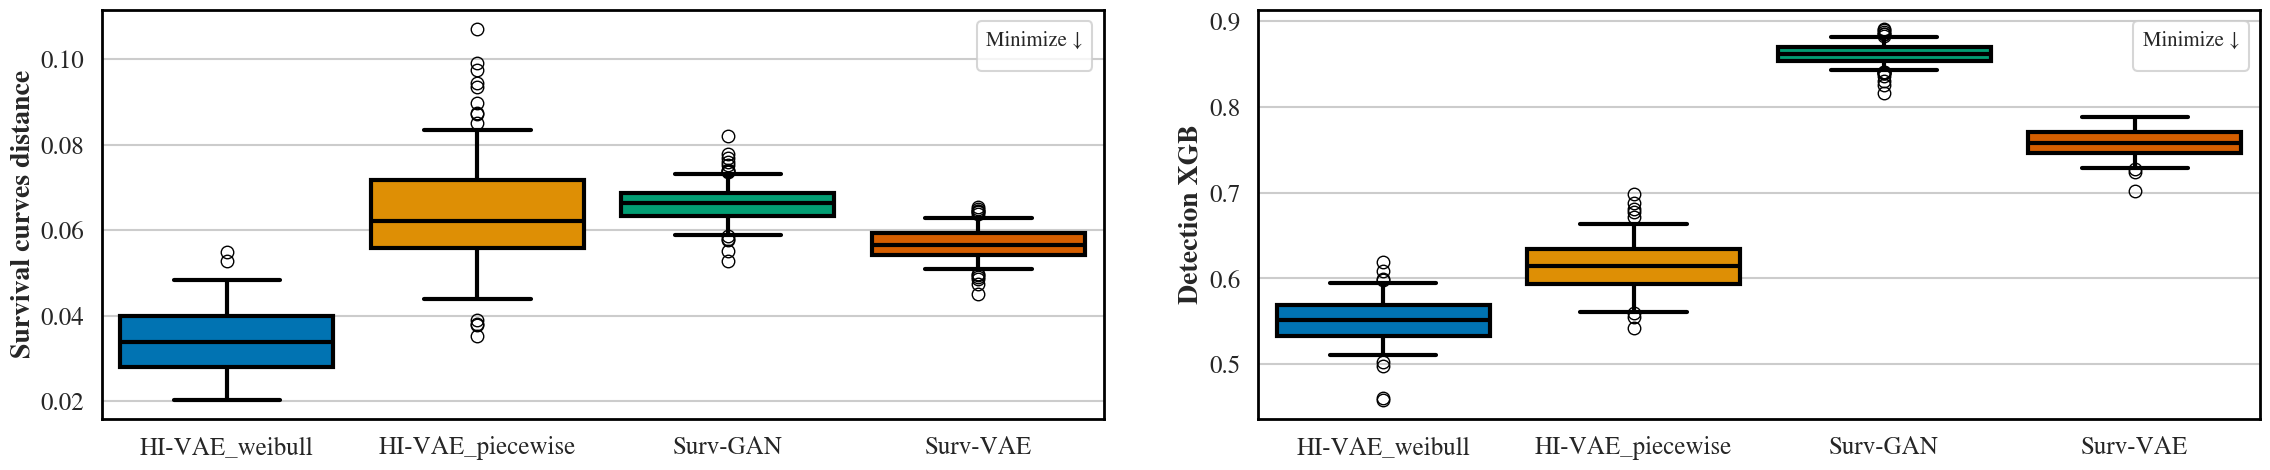

===================== General performance with best params logrank: =====================


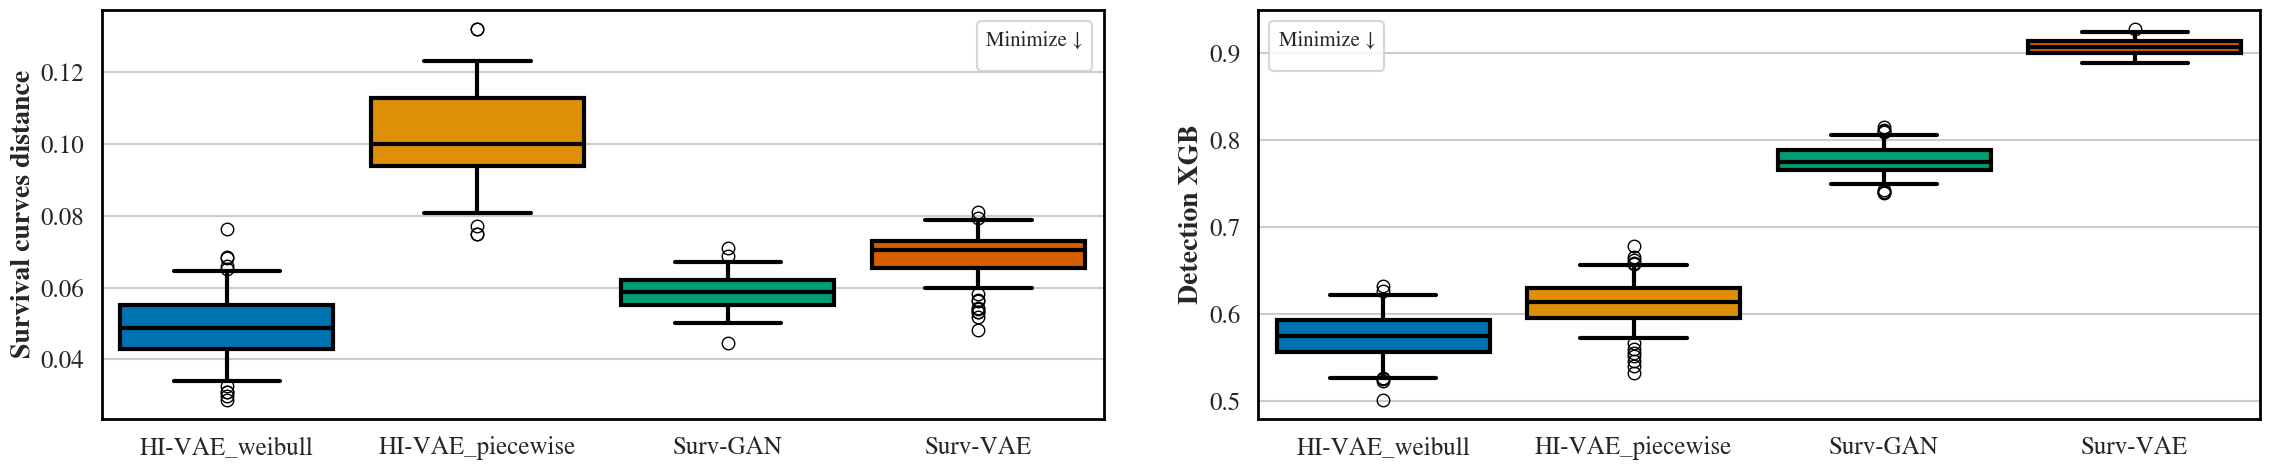

===================== General performance with default params: =====================


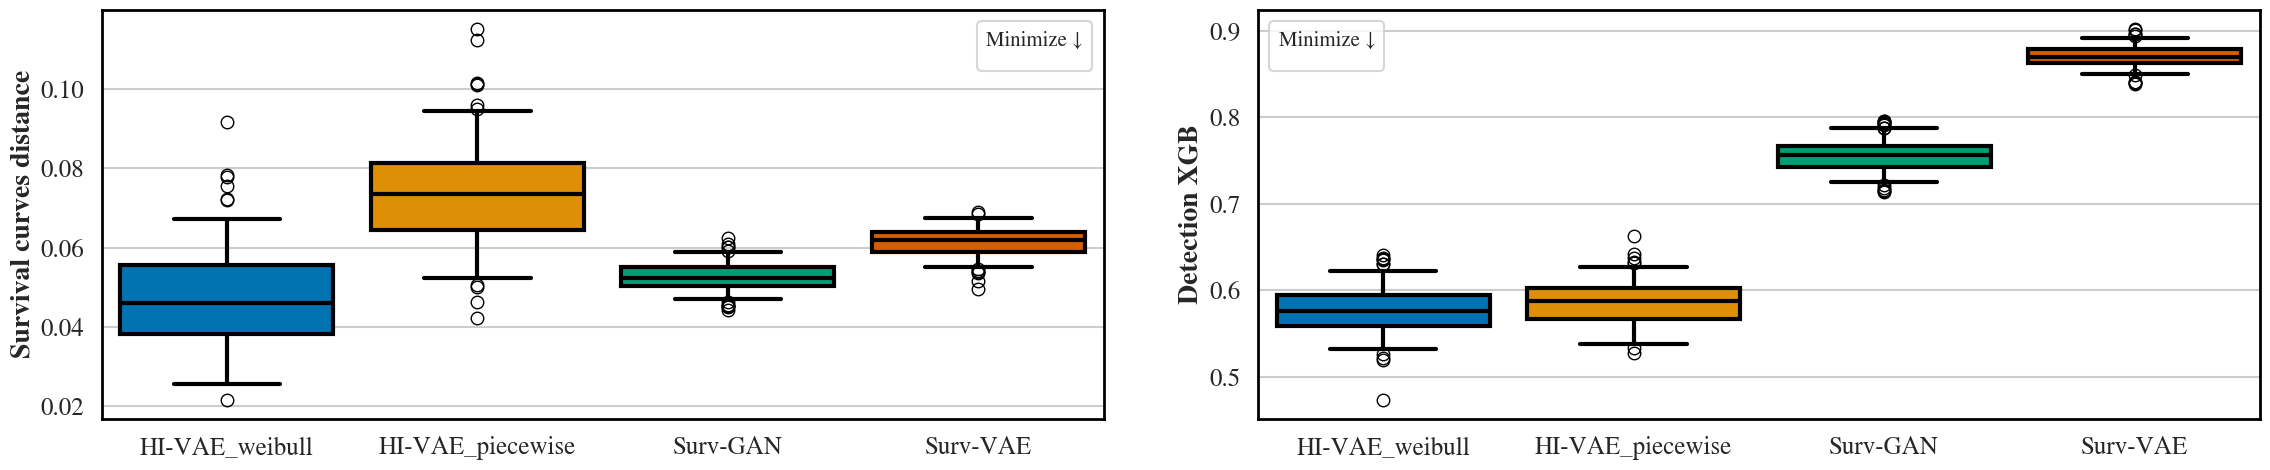

In [24]:
print("===================== General performance with best params survkm: =====================")
visualize_general_perf(general_scores_survkm_df, metrics=[['Survival curves distance', "min"], ['Detection XGB', "min"]])

print("===================== General performance with best params logrank: =====================")
visualize_general_perf(general_scores_logrank_df, metrics=[['Survival curves distance', "min"], ['Detection XGB', "min"]])

print("===================== General performance with default params: =====================")
visualize_general_perf(general_scores_default_df, metrics=[['Survival curves distance', "min"], ['Detection XGB', "min"]])

#### 3.1.3. Privacy

===================== General performance with best params survkm: =====================


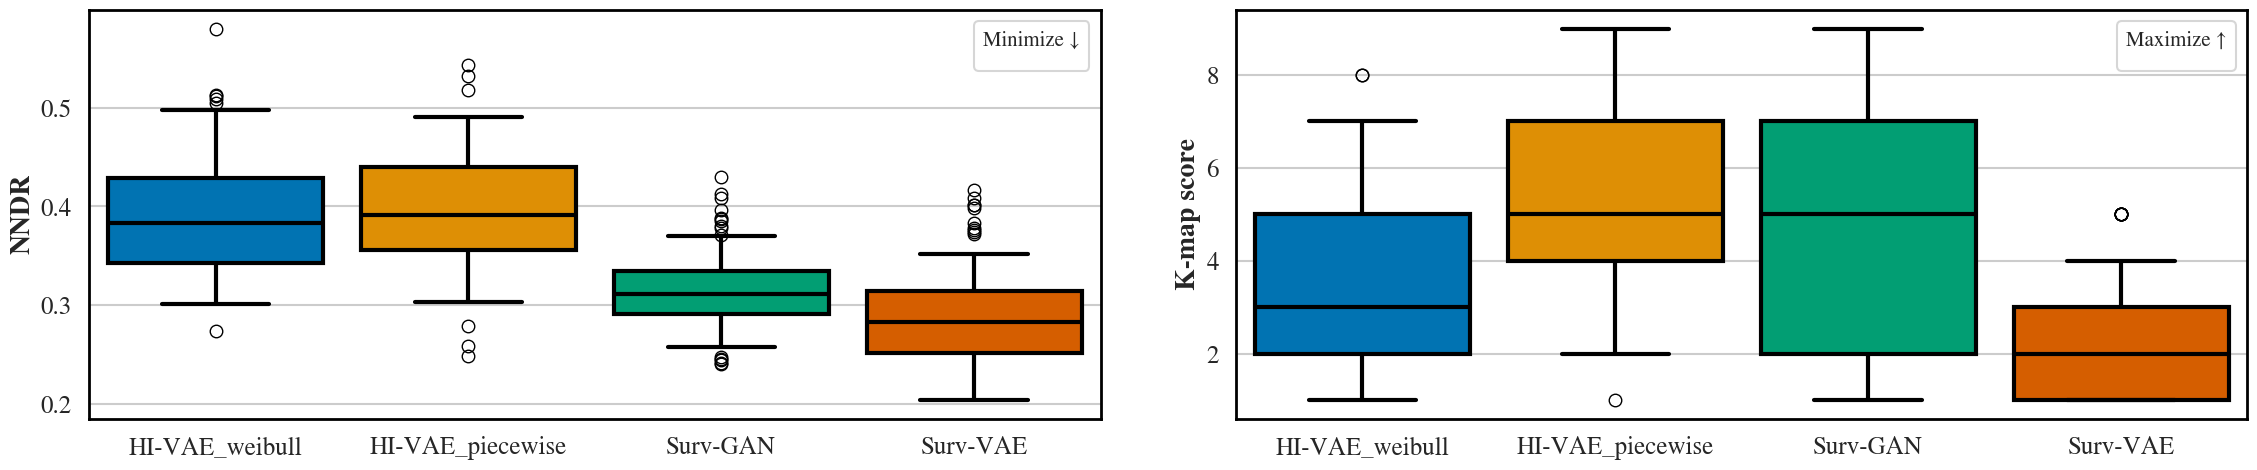

===================== General performance with best params logrank: =====================


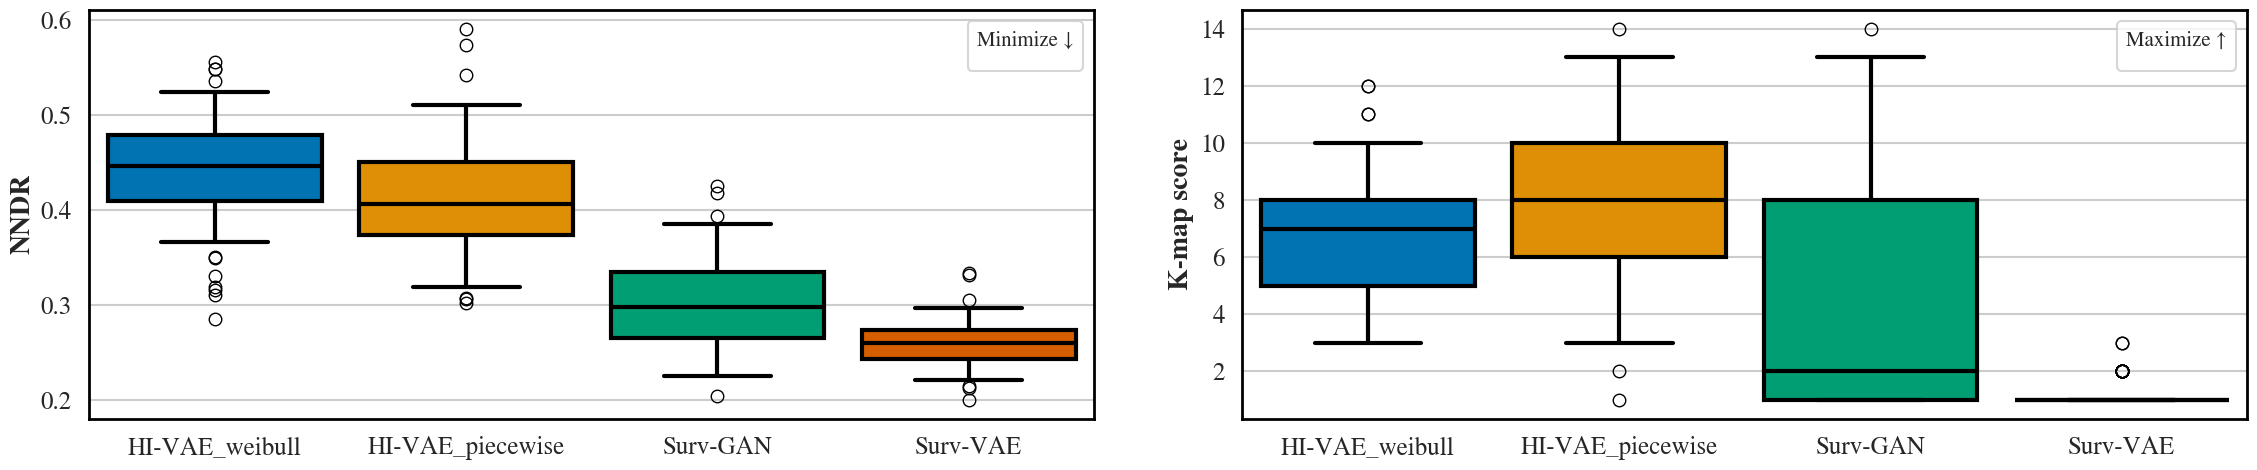

===================== General performance with default params: =====================


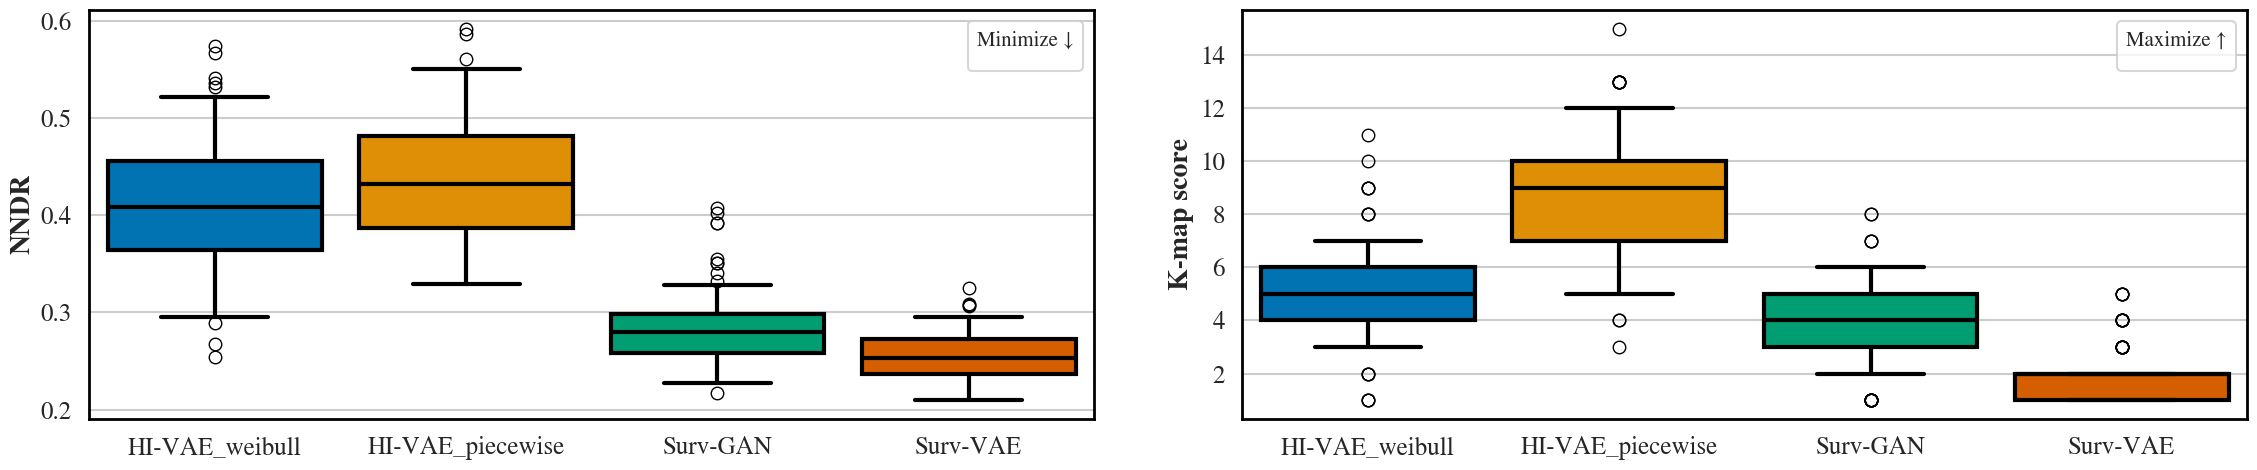

In [25]:
print("===================== General performance with best params survkm: =====================")
visualize_general_perf(general_scores_survkm_df, metrics=[['NNDR', "min"], ['K-map score', "max"]])

print("===================== General performance with best params logrank: =====================")
visualize_general_perf(general_scores_logrank_df, metrics=[['NNDR', "min"], ['K-map score', "max"]])

print("===================== General performance with default params: =====================")
visualize_general_perf(general_scores_default_df, metrics=[['NNDR', "min"], ['K-map score', "max"]])

#### Replicability metrics with best params

In [26]:
# choose the type of best parameters to use
df_syn_dict_best_params = df_syn_dict_best_params_survkm.copy()

In [35]:
from utils.metrics import replicability_ext
replicability_scores = []
for generator_name in generators_sel:
    replicability_scores.append(replicability_ext(df_init, df_syn_dict_best_params[generator_name], generator_name))
replicability_scores_df = pd.concat(replicability_scores, ignore_index=True)

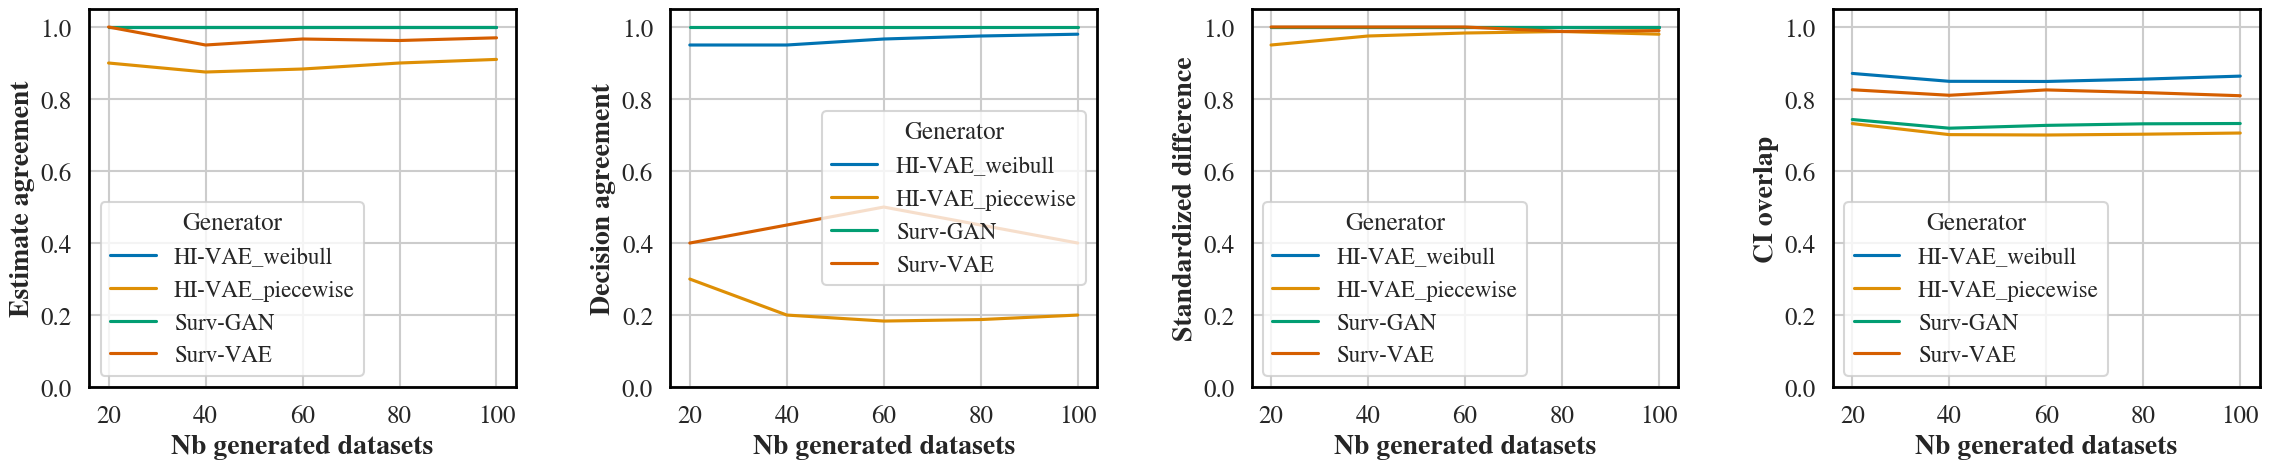

In [36]:
from utils.visualization import visualize_replicability_perf
visualize_replicability_perf(replicability_scores_df)

In [37]:
from utils.metrics import fit_cox_model
import numpy as np
columns = ['time', 'censor', 'treatment']
coef_init, _, ci_init, se_init = fit_cox_model(df_init, columns)
# Compute midpoints and widths
midpoints = [(ci_init[1] + ci_init[0]) / 2]
errors = [(ci_init[1] - ci_init[0]) / 2]
label = ["Init"]
colors = ['green', 'blue', 'orange', 'cyan']

colors_ = ['red']
for i , generator in enumerate(generators_sel):
    data_syn_ = df_syn_dict_best_params[generator]
    results = [fit_cox_model(data, columns) for data in data_syn_]
    coef_syn, _, _, se_syn = zip(*results)
    for n in range(10):
        coef_syn_, se_syn_ = np.array(coef_syn)[n][0], np.array(se_syn)[n][0]
        ci_syn = (coef_syn_ - 1.96 * se_syn_, coef_syn_ + 1.96 * se_syn_)
        midpoints.append((ci_syn[1] + ci_syn[0]) / 2)
        errors.append((ci_syn[1] - ci_syn[0]) / 2)
        label.append(generator + " " + str(n + 1))
        colors_.append(colors[i])

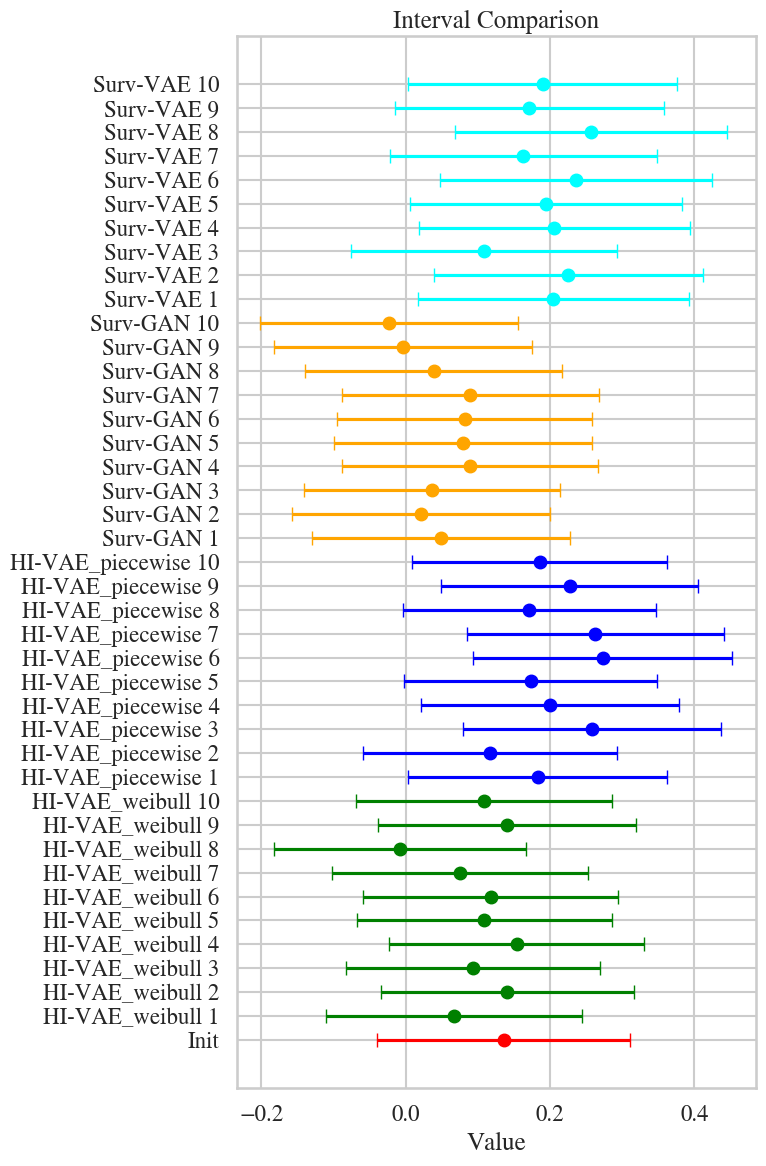

In [38]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 12))

# Plot as horizontal error bars
for i, (mid, err) in enumerate(zip(midpoints, errors)):
    ax.errorbar(x=mid, y=i, xerr=err, fmt='o', capsize=5, color=colors_[i])

plt.yticks(range(len(midpoints)), label)
plt.xlabel("Value")
plt.title("Interval Comparison")
plt.grid(True)
plt.tight_layout()
plt.show()